# Mental Impairment

In this notebook, we examine the relationship between mental impairment, socioeconomic status (SES), and life events for 40 subjects.

## Exploratory Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(suppress=True)

mental_impairment_data = pd.DataFrame([
    (1, 'Well', 1, 1),
    (2, 'Well', 1, 9),
    (3, 'Well', 1, 4),
    (4, 'Well', 1, 3),
    (5, 'Well', 0, 2),
    (6, 'Well', 1, 0),
    (7, 'Well', 0, 1),
    (8, 'Well', 1, 3),
    (9, 'Well', 1, 3),
    (10, 'Well', 1, 7),
    (11, 'Well', 0, 1),
    (12, 'Well', 0, 2),
    (13, 'Mild', 1, 5),
    (14, 'Mild', 0, 6),
    (15, 'Mild', 1, 3),
    (16, 'Mild', 0, 1),
    (17, 'Mild', 1, 8),
    (18, 'Mild', 1, 2),
    (19, 'Mild', 0, 5),
    (20, 'Mild', 1, 5),
    (21, 'Mild', 1, 9),
    (22, 'Mild', 0, 3),
    (23, 'Mild', 1, 3),
    (24, 'Mild', 1, 1),
    (25, 'Moderate', 0, 0),
    (26, 'Moderate', 1, 4),
    (27, 'Moderate', 0, 3),
    (28, 'Moderate', 0, 9),
    (29, 'Moderate', 1, 6),
    (30, 'Moderate', 0, 4),
    (31, 'Moderate', 0, 3),
    (32, 'Impaired', 1, 8),
    (33, 'Impaired', 1, 2),
    (34, 'Impaired', 1, 7),
    (35, 'Impaired', 0, 5),
    (36, 'Impaired', 0, 4),
    (37, 'Impaired', 0, 4),
    (38, 'Impaired', 1, 8),
    (39, 'Impaired', 0, 8),
    (40, 'Impaired', 0, 9),
], columns=['Subject', 'Mental Impairment', 'SES', 'Life Events'])

mental_impairment_data = mental_impairment_data.set_index('Subject')
mental_impairment_data.to_csv('mental_impairment.csv')
with open('p1_data.tex', 'w') as f:
    f.write(mental_impairment_data.reset_index().to_latex(index=False))
mental_impairment_data['Impaired'] = np.isin(
    mental_impairment_data['Mental Impairment'].values, ['Moderate', 'Impaired'])
mental_impairment_data

,Mental Impairment,SES,Life Events,Impaired
Subject,,,,
1,Well,1,1,False
2,Well,1,9,False
3,Well,1,4,False
4,Well,1,3,False
5,Well,0,2,False
6,Well,1,0,False
7,Well,0,1,False
8,Well,1,3,False
9,Well,1,3,False


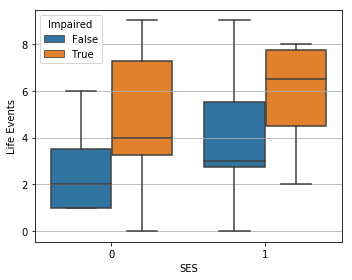

In [2]:
fig = plt.figure(figsize=(5,4))
ax = fig.gca()
ax.grid(True)
sns.boxplot(x='SES', y='Life Events', hue='Impaired', data=mental_impairment_data, ax=ax)
fig.tight_layout()
fig.savefig('p1_descriptive.pdf', bbox_inches='tight')

## Logistic Model

In [3]:
import collections

from scipy import linalg
from scipy import optimize
from scipy import special
from scipy import stats

X = np.column_stack((
    np.ones_like(mental_impairment_data['Impaired']), mental_impairment_data[['SES', 'Life Events']]))
z = mental_impairment_data['Impaired'].values.astype(np.int64)

In [4]:
def score(X, z, gamma):
    weight = (2*z - 1)/(1 + np.exp((2*z - 1)*np.matmul(X, gamma)))
    return np.sum(weight[:,np.newaxis]*X, axis=0)

def fisher_information(X, gamma):
    outer_products = np.vectorize(lambda x, y: np.outer(x, y), signature='(m),(m)->(m,m)')(X, X)
    weights = np.matmul(X, gamma)
    weights = 1/(2 + np.exp(weights) + np.exp(-weights))    
    return np.sum(weights[:,np.newaxis,np.newaxis]*outer_products, 0)

def fit_logistic_regression(X, z):
    gamma_hat = optimize.root(lambda gamma: score(X, z, gamma), [0., 0., 0.])
    assert gamma_hat.success, 'Estimate should converge.'
    gamma_hat = gamma_hat.x
    gamma_hat_variance = linalg.cho_solve(linalg.cho_factor(fisher_information(X, gamma_hat)),
                                          np.eye(len(gamma_hat)))
    return gamma_hat, gamma_hat_variance

def summarize_model(gamma_hat, gamma_hat_variance):
    return pd.DataFrame(collections.OrderedDict([
        ('Estimate', gamma_hat),
        ('Standard error', np.sqrt(np.diag(gamma_hat_variance))),
        ('95\% CI lower bound', gamma_hat + np.sqrt(np.diag(gamma_hat_variance))*stats.norm.ppf(0.025)),
        ('95\% CI upper bound', gamma_hat + np.sqrt(np.diag(gamma_hat_variance))*stats.norm.ppf(0.975)),
    ]), index=['$\gamma_{}$'.format(j) for j in range(len(gamma_hat))])

gamma_hat, gamma_hat_variance = fit_logistic_regression(X, z)
gamma_hat_summary = summarize_model(gamma_hat, gamma_hat_variance)

with open('p3_gamma_hat.tex', 'w') as f:
    f.write(gamma_hat_summary.to_latex(escape=False))

gamma_hat_summary

,Estimate,Standard error,95\% CI lower bound,95\% CI upper bound
$\gamma_0$,-0.925065,0.723346,-2.342797,0.492666
$\gamma_1$,-1.629731,0.780849,-3.160167,-0.099296
$\gamma_2$,0.309899,0.147920,0.019980,0.599818


## Prediction

In [5]:
log_odds_ratio_estimates = pd.DataFrame(collections.OrderedDict([
    ('Count', mental_impairment_data.groupby(['SES', 'Life Events']).size()),    
]))

X_unique = np.column_stack((np.ones(log_odds_ratio_estimates.count()),
                            np.array(list(log_odds_ratio_estimates.index.values))))
log_odds_ratio_estimates['Estimate'] = np.matmul(X_unique, gamma_hat)
log_odds_ratio_estimates['Standard error'] = (
    np.sqrt(np.vectorize(lambda x, y: x.dot(gamma_hat_variance).dot(y), signature='(m),(m)->()')(X_unique, X_unique)))
log_odds_ratio_estimates['95% CI lower bound'] = (
    log_odds_ratio_estimates['Estimate'] + log_odds_ratio_estimates['Standard error']*stats.norm.ppf(0.025))
log_odds_ratio_estimates['95% CI upper bound'] = (
    log_odds_ratio_estimates['Estimate'] + log_odds_ratio_estimates['Standard error']*stats.norm.ppf(0.975))

log_odds_ratio_estimates

Count  Estimate  Standard error  95% CI lower bound  \
SES Life Events                                                        
0   0                1 -0.925065        0.723346           -2.342797   
    1                3 -0.615166        0.626483           -1.843051   
    2                2 -0.305268        0.552715           -1.388569   
    3                3  0.004631        0.512121           -0.999107   
    4                3  0.314530        0.512643           -0.690231   
    5                2  0.624429        0.554164           -0.461713   
    6                1  0.934328        0.628613           -0.297731   
    8                1  1.554126        0.838183           -0.088683   
    9                2  1.864024        0.960151           -0.017837   
1   0                1 -2.554797        0.964303           -4.444795   
    1                2 -2.244898        0.842585           -3.896334   
    2                2 -1.934999        0.730602           -3.366953   
    3                5 -1.625100        0.633538           -2.866812   
    4                2 -1.315201        0.559216           -2.411245   
    5                2 -1.005302        0.517529           -2.019640   
    6                1 -0.695404        0.516440           -1.707607   
    7                2 -0.385505        0.556188           -1.475613   
    8                3 -0.075606        0.629079           -1.308579   
    9                2  0.234293        0.725188           -1.187049   

                 95% CI upper bound  
SES Life Events                      
0   0                      0.492666  
    1                      0.612718  
    2                      0.778034  
    3                      1.008370  
    4                      1.319291  
    5                      1.710571  
    6                      2.166387  
    8                      3.196934  
    9                      3.745885  
1   0                     -0.664798  
    1                     -0.593462  
    2                     -0.503045  
    3                     -0.383388  
    4                     -0.219157  
    5                      0.009036  
    6                      0.316800  
    7                      0.704604  
    8                      1.157367  
    9                      1.655635

In [6]:
odds_ratio_estimates = log_odds_ratio_estimates.copy()
odds_ratio_estimates = odds_ratio_estimates.drop(columns=['Standard error'])
odds_ratio_estimates['Estimate'] = np.exp(odds_ratio_estimates['Estimate'])
odds_ratio_estimates['95% CI lower bound'] = np.exp(odds_ratio_estimates['95% CI lower bound'])
odds_ratio_estimates['95% CI upper bound'] = np.exp(odds_ratio_estimates['95% CI upper bound'])

with open('p3_odds_ratios.tex', 'w') as f:
    f.write(odds_ratio_estimates.to_latex())

odds_ratio_estimates

Count  Estimate  95% CI lower bound  95% CI upper bound
SES Life Events                                                         
0   0                1  0.396506            0.096059            1.636675
    1                3  0.540551            0.158334            1.845440
    2                2  0.736926            0.249432            2.177188
    3                3  1.004642            0.368208            2.741129
    4                3  1.369616            0.501460            3.740769
    5                2  1.867180            0.630203            5.532120
    6                1  2.545502            0.742501            8.726699
    8                1  4.730948            0.915136           24.457420
    9                2  6.449640            0.982321           42.346488
1   0                1  0.077708            0.011740            0.514377
    1                2  0.105938            0.020316            0.552412
    2                2  0.144424            0.034495            0.604687
    3                5  0.196892            0.056880            0.681549
    4                2  0.268420            0.089704            0.803195
    5                2  0.365934            0.132703            1.009076
    6                1  0.498873            0.181299            1.372728
    7                2  0.680107            0.228639            2.023045
    8                3  0.927182            0.270204            3.181546
    9                2  1.264015            0.305120            5.236406

## Proportional Odds Model

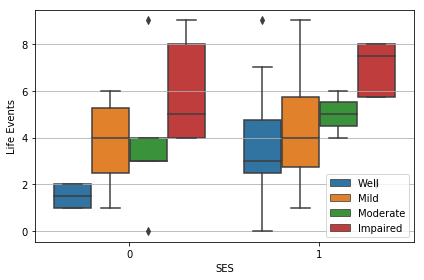

In [7]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
ax.grid(True)

sns.boxplot(x='SES', y='Life Events', hue='Mental Impairment',
            data=mental_impairment_data, ax=ax)
ax.legend(loc='lower right')

fig.tight_layout()
fig.savefig('p6_descriptive.pdf', bbox_inches='tight')

In [44]:
np.sqrt(np.vectorize(lambda x, y: x.dot(gamma_hat_variance).dot(y), signature='(m),(m)->()')(X_unique, X_unique))

array([0.72334578, 0.62648312, 0.5527151 , 0.51212086, 0.51264264,
       0.55416432, 0.62861325, 0.8381828 , 0.96015085, 0.96430273,
       0.84258484, 0.7306022 , 0.63353836, 0.55921645, 0.51752887,
       0.51643987, 0.55618798, 0.6290794 , 0.725188  ])

In [43]:
X_unique[4].dot(gamma_hat_variance).dot(X_unique[4])

0.26280247722098693

In [298]:
gamma_hat_variance = linalg.cho_solve(linalg.cho_factor(fisher_information(np.vstack((X,X)), gamma)), np.eye(len(gamma)))
x = np.array([1,1,1])
x.dot(gamma_hat_variance.dot(x))

0.354974602779418

In [299]:
gamma_hat_summary['Estimate'].dot(x)

-2.2448977871026496

In [300]:
np.random.seed(2018)
success = 0
num_trials = 2000
for i in range(num_trials):
    y = stats.bernoulli.rvs(special.expit(np.matmul(np.vstack((X,X)), gamma_hat_summary['Estimate'])))    
    estimates = fit_logistic_regression(np.vstack((X,X)), y) 
    success += np.abs(estimates['Estimate'].dot(x) - (-2.2448977870557685)) <= stats.norm.ppf(0.975)*np.sqrt(0.354974602779418)
    #success += estimates['95\% CI lower bound'][0] <= gamma_hat_summary['Estimate'][0] and gamma_hat_summary['Estimate'][1] <= estimates['95\% CI upper bound'][0]
    
success/num_trials

0.921

In [256]:
np.vstack((X,X)).shape

(80, 3)

In [261]:
success/num_trials

0.942

In [190]:
q = special.expit(np.matmul(X, gamma))
#np.outer(z - q, z - q)
q*(1-q)

array([0.01314517, 0.10279626, 0.13366754, 0.23986298, 0.04215337,
       0.03638381, 0.09203672, 0.07686816, 0.03806022, 0.02513363,
       0.2240548 , 0.05971563, 0.24904511, 0.19873035, 0.12543827,
       0.21378295, 0.17567532, 0.24338646, 0.10141109, 0.24968737,
       0.24724797, 0.24964683, 0.06271876, 0.23756594, 0.24542109,
       0.09002994, 0.23754954, 0.1546219 , 0.15098517, 0.0190094 ,
       0.24825827, 0.01883503, 0.03358891, 0.01587927, 0.12363228,
       0.20516338, 0.18869308, 0.2370747 , 0.09439047, 0.18812552,
       0.02236262, 0.12105226, 0.12749297, 0.24722869, 0.17522108,
       0.24904442, 0.23579483, 0.20312271, 0.24757001, 0.09527472,
       0.0716536 , 0.22027522, 0.15372657, 0.04406568, 0.14866537,
       0.2499941 , 0.20002082, 0.0244127 , 0.05003317, 0.24967862,
       0.06061112, 0.07000361, 0.15575888, 0.07422648, 0.24912318,
       0.10826981, 0.05223083, 0.19324835, 0.21577934, 0.09274465,
       0.21041603, 0.12610562, 0.06004873, 0.1948146 , 0.15652

In [192]:
1/(2 + np.exp(np.matmul(X, gamma)) + np.exp(-np.matmul(X, gamma)))

array([0.01314517, 0.10279626, 0.13366754, 0.23986298, 0.04215337,
       0.03638381, 0.09203672, 0.07686816, 0.03806022, 0.02513363,
       0.2240548 , 0.05971563, 0.24904511, 0.19873035, 0.12543827,
       0.21378295, 0.17567532, 0.24338646, 0.10141109, 0.24968737,
       0.24724797, 0.24964683, 0.06271876, 0.23756594, 0.24542109,
       0.09002994, 0.23754954, 0.1546219 , 0.15098517, 0.0190094 ,
       0.24825827, 0.01883503, 0.03358891, 0.01587927, 0.12363228,
       0.20516338, 0.18869308, 0.2370747 , 0.09439047, 0.18812552,
       0.02236262, 0.12105226, 0.12749297, 0.24722869, 0.17522108,
       0.24904442, 0.23579483, 0.20312271, 0.24757001, 0.09527472,
       0.0716536 , 0.22027522, 0.15372657, 0.04406568, 0.14866537,
       0.2499941 , 0.20002082, 0.0244127 , 0.05003317, 0.24967862,
       0.06061112, 0.07000361, 0.15575888, 0.07422648, 0.24912318,
       0.10826981, 0.05223083, 0.19324835, 0.21577934, 0.09274465,
       0.21041603, 0.12610562, 0.06004873, 0.1948146 , 0.15652

In [132]:
odds_ratio_estimates = pd.DataFrame({
    'Count': mental_impairment_data.groupby(['SES', 'Life Events']).size(),
})
for i in odds_ratio_estimates.index:
    print(i)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)


In [112]:
print(log_likelihood(np.negative([ 0.92506522,  1.62973142, -0.30989884])))
log_likelihood([ 0.92506522,  1.62973142, -0.30989884])

-22.680460908852503


-45.44860034885251

In [68]:
1/(1 + np.exp(-np.matmul(X, [0.92506522,  1.62973142, -0.30989884])))

array([0.90420952, 0.44169325, 0.78838222, 0.8354973 , 0.5757297 ,
       0.9278951 , 0.64911842, 0.8354973 , 0.8354973 , 0.5952001 ,
       0.64911842, 0.5757297 , 0.73209982, 0.28204752, 0.8354973 ,
       0.64911842, 0.51889248, 0.8738017 , 0.34877482, 0.73209982,
       0.44169325, 0.49884218, 0.8354973 , 0.90420952, 0.71607305,
       0.78838222, 0.49884218, 0.13423467, 0.6671679 , 0.42200937,
       0.49884218, 0.51889248, 0.8738017 , 0.5952001 , 0.34877482,
       0.42200937, 0.42200937, 0.51889248, 0.17449122, 0.13423467])

In [27]:
from sklearn import linear_model

In [154]:
tmp = linear_model.LogisticRegression(C=100000000, fit_intercept=False)
tmp.fit(X, z)
tmp.coef_

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[-0.92511511, -1.62968645,  0.3099026 ]])

In [188]:
X = np.random.normal(size=(100,3))
y = np.random.normal(size=(100,))

X.T.dot(np.diagonal(np.outer(y, y))*np.eye(len(y))).dot(X)

array([[143.33623892,   6.30241789,  32.98148876],
       [  6.30241789, 121.63176689,  37.42449724],
       [ 32.98148876,  37.42449724, 139.75335225]])

In [189]:
np.sum(np.vectorize(lambda x, y: np.outer(x, y),
             signature='(m),(m)->(m,m)')(X,X)*np.expand_dims(np.expand_dims(y, -1), -1)**2, 0)

array([[143.33623892,   6.30241789,  32.98148876],
       [  6.30241789, 121.63176689,  37.42449724],
       [ 32.98148876,  37.42449724, 139.75335225]])

In [178]:
np.outer(X[0], X[0])*y[0]*y[0]

array([[ 0.02017422,  0.01853516, -0.00230682],
       [ 0.01853516,  0.01702928, -0.00211941],
       [-0.00230682, -0.00211941,  0.00026377]])